In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import numpy as np
import os
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Concatenate
import keras.backend as K
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, Callback
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

Using TensorFlow backend.


# Data processing

In [2]:
## First, download the Skin Cancer MNIST data from https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

PATH = '/home/juyeon/skin_cancer/'
os.chdir(PATH)
print("current path: ",os.getcwd())

current path:  /home/juyeon/skin_cancer


In [3]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

num_classes = 7

In [4]:
skin_df = pd.read_csv('HAM10000_metadata.csv')
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033084.jpg,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033550.jpg,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033536.jpg,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,HAM10000_images_part_2/ISIC_0032854.jpg,Actinic keratoses,0


In [5]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [6]:
skin_df = skin_df.drop(skin_df[skin_df['sex']=='unknown'].index)
skin_df = skin_df.drop(skin_df[skin_df['localization']=='unknown'].index)
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033084.jpg,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033550.jpg,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033536.jpg,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,HAM10000_images_part_2/ISIC_0032854.jpg,Actinic keratoses,0


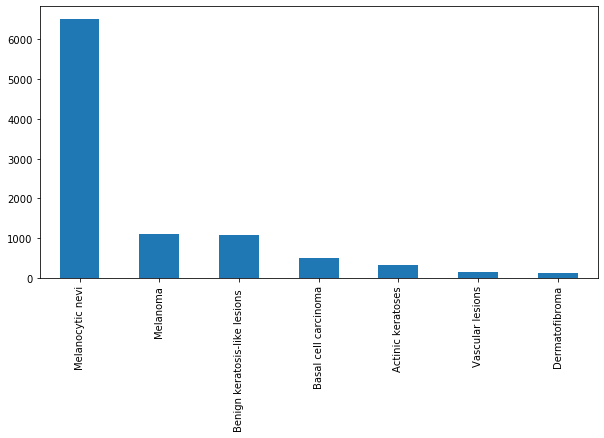

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [8]:
## skin cancer: Basal cell carcinoma (1) and Melanoma (5)

skin_df[['cell_type','cell_type_idx']].drop_duplicates().sort_values(by='cell_type_idx')

,cell_type,cell_type_idx
9687,Actinic keratoses,0
2462,Basal cell carcinoma,1
0,Benign keratosis-like lesions,2
1095,Dermatofibroma,3
64,Melanocytic nevi,4
1211,Melanoma,5
2320,Vascular lesions,6


In [9]:
skin_df['sex_idx'] = pd.Categorical(skin_df['sex']).codes
skin_df['localization_idx'] = pd.Categorical(skin_df['localization']).codes
skin_df['localization_onehot'] = skin_df['localization_idx'].map(lambda x: to_categorical(x,num_classes=14))
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,sex_idx,localization_idx,localization_onehot
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,1,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,1,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,1,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,1,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,1,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [10]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((264,198))))

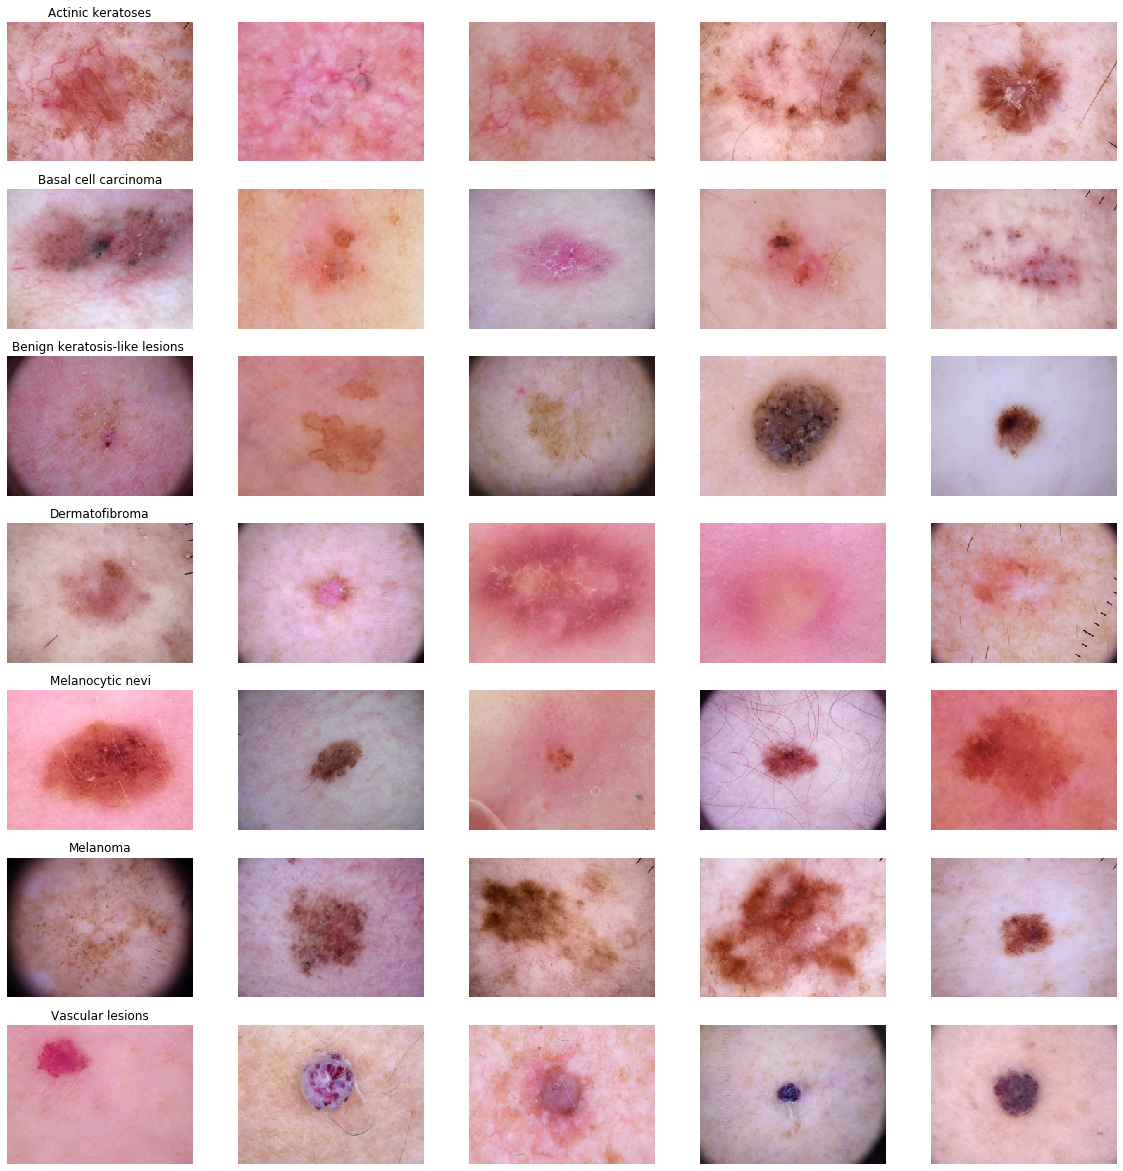

In [31]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [11]:
X = skin_df.drop(columns=['cell_type_idx'],axis=1)
Y = skin_df['cell_type_idx']

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,random_state=1234)

In [13]:
X_train_img = np.asarray(X_train['image'].tolist())
X_test_img = np.asarray(X_test['image'].tolist())

## Normalization
X_train_img = (X_train_img - np.mean(X_train_img))/np.std(X_train_img)
X_test_img = (X_test_img - np.mean(X_test_img))/np.std(X_test_img)

In [14]:
X_train_feat = X_train[['age','sex_idx','localization_onehot']].copy()
X_test_feat = X_test[['age','sex_idx', 'localization_onehot']].copy()

## Normalization
X_train_feat['age'] = (X_train_feat['age']-X_train_feat['age'].mean())/X_train_feat['age'].std()
X_test_feat['age'] = (X_test_feat['age']-X_test_feat['age'].mean())/X_test_feat['age'].std()

X_train_feat = np.array([np.append(x[:-1],x[-1]) for x in X_train_feat.values],dtype=float)
X_test_feat = np.array([np.append(x[:-1],x[-1]) for x in X_test_feat.values],dtype=float)

In [15]:
Y_train = to_categorical(Y_train, num_classes = num_classes)
Y_test = to_categorical(Y_test, num_classes = num_classes)

In [16]:
x_train_img, x_val_img, x_train_feat, x_val_feat, y_train, y_val = train_test_split(X_train_img, X_train_feat, Y_train, test_size = 0.1, random_state = 1234)

In [17]:
class MyCallback(Callback):
    def __init__(self,validation_data,patience):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.best_weight = None
        self.patience = patience
    def on_train_begin(self,logs={}):
        self.wait = 0
        self.stopped_epoch = 0
        self.best = -np.Inf
        return
    def on_train_end(self, logs={}):
        self.model.set_weights(self.best_weight)
        self.model.save('bestmodel.h5')
        if self.stopped_epoch > 0 :
            print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        if logs['val_acc'] > self.best:
            self.best = logs['val_acc']

            self.wait = 0
            self.best_weight = self.model.get_weights()
        else:
            self.wait+=1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
        return
        

In [18]:
def CustomGenerator(X1,X2,Y):
    while True:
        idx = np.random.permutation(X1.shape[0])
        gen = ImageDataGenerator(rotation_range=10, 
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1,
                                 zoom_range=0.1)
        
        batches = gen.flow(X1[idx], Y[idx], batch_size=32, shuffle = False)
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]
            
            yield [batch[0], X2[idx[idx0:idx1]]], batch[1]
            
            idx0= idx1
            
            if idx1 >= X1.shape[0]:
                break

# Models training (ResNet50/Xception)

In [24]:
## train with ResNet 50
model = ResNet50(include_top=False, weights=None, input_shape=(198,264,3))

fc_layer = [1024, 512, 256]
x = model.output
x = Flatten()(x)

for dim in fc_layer:
    x = Dense(dim)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(model.input, output)

optimizer = Adam()
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

datagen = ImageDataGenerator(rotation_range=10, 
                   width_shift_range=0.1, 
                   height_shift_range=0.1,
                   zoom_range=0.1)

epochs = 50
batch_size = 32

callbacks = [ModelCheckpoint('bestmodel.h5', monitor='val_acc', save_best_only=True, save_weights_only=False),
             MyCallback(validation_data = (x_val_img, y_val), patience=5),
             learning_rate_reduction]
history = model.fit_generator(datagen.flow(x_train_img,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val_img,y_val),
                              verbose = 1, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
248/248 [==============================] - 80s 323ms/step - loss: 0.9766 - acc: 0.6618 - val_loss: 1.9214 - val_acc: 0.6818
Epoch 2/50
248/248 [==============================] - 62s 251ms/step - loss: 0.9001 - acc: 0.6748 - val_loss: 0.8532 - val_acc: 0.6761
Epoch 3/50
248/248 [==============================] - 63s 253ms/step - loss: 0.8662 - acc: 0.6794 - val_loss: 0.8980 - val_acc: 0.6966
Epoch 4/50
248/248 [==============================] - 63s 252ms/step - loss: 0.8434 - acc: 0.6834 - val_loss: 1.0979 - val_acc: 0.6352
Epoch 5/50
248/248 [==============================] - 63s 253ms/step - loss: 0.8305 - acc: 0.6913 - val_loss: 0.9394 - val_acc: 0.6852
Epoch 6/50
248/248 [==============================] - 63s 252ms/step - loss: 0.8061 - acc: 0.6983 - val_loss: 0.8043 - val_acc: 0.7318
Epoch 7/50
248/248 [==============================] - 63s 254ms/step - loss: 0.7878 - acc: 0.7

In [27]:
loss, accuracy = model.evaluate(X_test_img, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

978/978 [==============================] - 3s 3ms/step
Test: accuracy = 0.771984  ;  loss = 0.618204


In [22]:
## train with ResNet50 using ImageNet weight

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

datagen = ImageDataGenerator(rotation_range=10, 
                   width_shift_range=0.1, 
                   height_shift_range=0.1,
                   zoom_range=0.1)

model = ResNet50(include_top=False, input_shape=(198,264,3))
fc_layer = [1024, 512, 256]
x = model.output
x = Flatten()(x)

for dim in fc_layer:
    x = Dense(dim)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(model.input, output)
optimizer = Adam()
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

epochs = 50
batch_size = 32

callbacks = [ModelCheckpoint('bestmodel.h5', monitor='val_acc', save_best_only=True, save_weights_only=False),
             MyCallback(validation_data = (x_val_img, y_val), patience=5),
             learning_rate_reduction]

history = model.fit_generator(datagen.flow(x_train_img,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val_img,y_val),
                              verbose = 1, callbacks=callbacks)

loss, accuracy = model.evaluate(X_test_img, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))


94658560/94653016 [==============================] - 7s 0us/step
Epoch 1/50
248/248 [==============================] - 83s 333ms/step - loss: 0.9899 - acc: 0.6604 - val_loss: 0.9616 - val_acc: 0.6693
Epoch 2/50
248/248 [==============================] - 63s 253ms/step - loss: 0.8249 - acc: 0.7028 - val_loss: 0.9588 - val_acc: 0.6750
Epoch 3/50
248/248 [==============================] - 63s 255ms/step - loss: 0.7622 - acc: 0.7177 - val_loss: 1.5576 - val_acc: 0.4500
Epoch 4/50
248/248 [==============================] - 63s 255ms/step - loss: 0.7392 - acc: 0.7262 - val_loss: 0.9074 - val_acc: 0.7205
Epoch 5/50
248/248 [==============================] - 63s 255ms/step - loss: 0.6955 - acc: 0.7446 - val_loss: 2.7830 - val_acc: 0.3295
Epoch 6/50
248/248 [==============================] - 64s 256ms/step - loss: 0.6668 - acc: 0.7552 - val_loss: 2.4719 - val_acc: 0.4068
Epoch 7/50
248/248 [==============================] - 63s 255ms/step - loss: 0.6590 - acc: 0.7585 - val_loss: 0.7886 - val_a

In [32]:
## Concatenate the feature matrix to train the model

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model = ResNet50(include_top=False, input_shape=(198,264,3))
fc_layer = [1024, 512, 256]
x = model.output
x = Flatten()(x)
x_ = Input(shape=(16,))
x = Concatenate()([x,x_])

for dim in fc_layer:
    x = Dense(dim)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model([model.input,x_], output)
optimizer = Adam()
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

epochs = 50
batch_size = 32

callbacks = [ModelCheckpoint('bestmodel.h5', monitor='val_acc', save_best_only=True, save_weights_only=False),
             MyCallback(validation_data = (x_val_img, y_val), patience=5),
             learning_rate_reduction]

history = model.fit_generator(CustomGenerator(x_train_img, x_train_feat,y_train),
                              steps_per_epoch = len(x_train_img)//batch_size,
                              epochs = epochs, validation_data = ([x_val_img,x_val_feat],y_val),
                              verbose = 1, callbacks=callbacks)

loss, accuracy = model.evaluate([X_test_img, X_test_feat], Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))


Epoch 1/50
247/247 [==============================] - 83s 337ms/step - loss: 1.0225 - acc: 0.6733 - val_loss: 1.0347 - val_acc: 0.6818
Epoch 2/50
247/247 [==============================] - 63s 256ms/step - loss: 0.8271 - acc: 0.7057 - val_loss: 0.9601 - val_acc: 0.6477
Epoch 3/50
247/247 [==============================] - 66s 265ms/step - loss: 0.7657 - acc: 0.7178 - val_loss: 0.8031 - val_acc: 0.7034
Epoch 4/50
247/247 [==============================] - 65s 264ms/step - loss: 0.7512 - acc: 0.7259 - val_loss: 0.7679 - val_acc: 0.7159
Epoch 5/50
247/247 [==============================] - 64s 261ms/step - loss: 0.7494 - acc: 0.7270 - val_loss: 2.2493 - val_acc: 0.6818
Epoch 6/50
247/247 [==============================] - 66s 267ms/step - loss: 0.7158 - acc: 0.7388 - val_loss: 0.6802 - val_acc: 0.7250
Epoch 7/50
247/247 [==============================] - 64s 257ms/step - loss: 0.6597 - acc: 0.7564 - val_loss: 0.8358 - val_acc: 0.6864
Epoch 8/50
247/247 [==============================] - 

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 198, 264, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 99, 132, 64)  9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 99, 132, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 99, 132, 64)  0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [29]:
## train with Xception

model = Xception(include_top=False, weights=None, input_shape=(198,264,3))
fc_layer = [1024, 512, 256]
x = model.output
x = Flatten()(x)

for dim in fc_layer:
    x = Dense(dim)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(model.input, output)
optimizer = Adam()
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])


history = model.fit_generator(datagen.flow(x_train_img,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val_img,y_val),
                              verbose = 1, callbacks=callbacks)

loss, accuracy = model.evaluate(X_test_img, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Epoch 1/50
248/248 [==============================] - 133s 536ms/step - loss: 0.9357 - acc: 0.6694 - val_loss: 0.9249 - val_acc: 0.7011
Epoch 2/50
248/248 [==============================] - 111s 448ms/step - loss: 0.8807 - acc: 0.6844 - val_loss: 1.0471 - val_acc: 0.6341
Epoch 3/50
248/248 [==============================] - 113s 456ms/step - loss: 0.8061 - acc: 0.7037 - val_loss: 1.1844 - val_acc: 0.5318
Epoch 4/50
248/248 [==============================] - 113s 458ms/step - loss: 0.7577 - acc: 0.7119 - val_loss: 0.8371 - val_acc: 0.6511
Epoch 5/50
248/248 [==============================] - 113s 457ms/step - loss: 0.7269 - acc: 0.7302 - val_loss: 0.6605 - val_acc: 0.7545
Epoch 6/50
248/248 [==============================] - 113s 456ms/step - loss: 0.7053 - acc: 0.7341 - val_loss: 0.7284 - val_acc: 0.7409
Epoch 7/50
248/248 [==============================] - 114s 458ms/step - loss: 0.6856 - acc: 0.7466 - val_loss: 0.7357 - val_acc: 0.7636
Epoch 8/50
248/248 [============================

In [17]:
## train with Xception using ImageNet weight
## best performance model

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

datagen = ImageDataGenerator(rotation_range=10, 
                   width_shift_range=0.1, 
                   height_shift_range=0.1,
                   zoom_range=0.1)

model = Xception(include_top=False, input_shape=(198,264,3))
fc_layer = [1024, 512, 256]
x = model.output
x = Flatten()(x)

for dim in fc_layer:
    x = Dense(dim)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(model.input, output)
optimizer = Adam()
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

epochs = 50
batch_size = 32

callbacks = [ModelCheckpoint('bestmodel.h5', monitor='val_acc', save_best_only=True, save_weights_only=False),
             MyCallback(validation_data = (x_val_img, y_val), patience=5),
             learning_rate_reduction]

history = model.fit_generator(datagen.flow(x_train_img,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val_img,y_val),
                              verbose = 1, callbacks=callbacks)

loss, accuracy = model.evaluate(X_test_img, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
248/248 [==============================] - 131s 530ms/step - loss: 0.8657 - acc: 0.6997 - val_loss: 0.9499 - val_acc: 0.7273
Epoch 2/50
248/248 [==============================] - 117s 471ms/step - loss: 0.6490 - acc: 0.7694 - val_loss: 0.8461 - val_acc: 0.7284
Epoch 3/50
248/248 [==============================] - 118s 476ms/step - loss: 0.5525 - acc: 0.8024 - val_loss: 0.6489 - val_acc: 0.7420
Epoch 4/50
248/248 [==============================] - 118s 478ms/step - loss: 0.4915 - acc: 0.8296 - val_loss: 0.9202 - val_acc: 0.7136
Epoch 5/50
248/248 [==============================] - 120s 482ms/step - loss: 0.4650 - acc: 0.8350 - val_loss: 0.5603 - val_acc: 0.8125
Epoch 6/50
248/248 [==============================] - 119s 478ms/step - loss: 0.4007 - acc: 0.8631 - val_loss: 0.7156 - val_acc: 0.7614
Epoch 7/50
248/248 [==============================] - 119s 481ms/step - lo

In [19]:
## Concatenate the feature matrix to train the model

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model = Xception(include_top=False, input_shape=(198,264,3))
fc_layer = [1024, 512, 256]
x = model.output
x = Flatten()(x)
x_ = Input(shape=(16,))
x = Concatenate()([x,x_])

for dim in fc_layer:
    x = Dense(dim)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model([model.input,x_], output)
optimizer = Adam()
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

epochs = 50
batch_size = 32

callbacks = [ModelCheckpoint('bestmodel.h5', monitor='val_acc', save_best_only=True, save_weights_only=False),
             MyCallback(validation_data = (x_val_img, y_val), patience=5),
             learning_rate_reduction]

history = model.fit_generator(CustomGenerator(x_train_img, x_train_feat,y_train),
                              steps_per_epoch = len(x_train_img)//batch_size,
                              epochs = epochs, validation_data = ([x_val_img,x_val_feat],y_val),
                              verbose = 1, callbacks=callbacks)

loss, accuracy = model.evaluate([X_test_img, X_test_feat], Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
247/247 [==============================] - 127s 516ms/step - loss: 0.8609 - acc: 0.7062 - val_loss: 0.6986 - val_acc: 0.7477
Epoch 2/50
247/247 [==============================] - 111s 448ms/step - loss: 0.6536 - acc: 0.7707 - val_loss: 0.9067 - val_acc: 0.7193
Epoch 3/50
247/247 [==============================] - 113s 456ms/step - loss: 0.5708 - acc: 0.7980 - val_loss: 0.6000 - val_acc: 0.7943
Epoch 4/50
247/247 [==============================] - 113s 456ms/step - loss: 0.4878 - acc: 0.8287 - val_loss: 0.6084 - val_acc: 0.7807
Epoch 5/50
247/247 [==============================] - 113s 458ms/step - loss: 0.4354 - acc: 0.8489 - val_loss: 0.5823 - val_acc: 0.8080
Epoch 6/50
247/247 [==============================] - 113s 456ms/step - loss: 0.3737 - acc: 0.8726 - val_loss: 0.6647 - val_acc: 0.7818
Epoch 7/50
247/247 [==============================] - 113s 458ms/step - lo

# Visualize the Results

Text(0.5, 15.0, 'Predicted label')

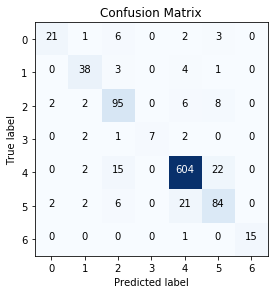

In [113]:
y_test_pred = model.predict([X_test_img,X_test_feat])
y_test_pred_label = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(Y_test,axis=1)

matrix = confusion_matrix(y_test_true, y_test_pred_label)

plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(np.arange(7),range(7))
plt.yticks(np.arange(7),range(7))
for i,j in itertools.product(range(matrix.shape[0]), range(matrix.shape[0])):
    plt.text(j,i,matrix[i,j],
             horizontalalignment='center',
             color='white' if matrix[i,j]>300 else 'black')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 15.0, 'Predicted label')

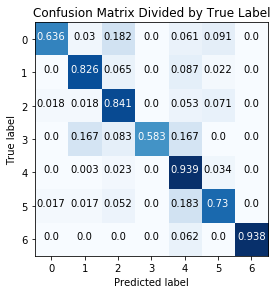

In [112]:
norm_matrix = np.array([matrix[i]/matrix.sum(axis=1)[i] for i in range(7)])
plt.imshow(norm_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix Divided by True Label')
plt.xticks(np.arange(7),range(7))
plt.yticks(np.arange(7),range(7))
for i,j in itertools.product(range(matrix.shape[0]), range(matrix.shape[0])):
    plt.text(j,i,round(norm_matrix[i,j],3),
             horizontalalignment='center',
             color='white' if norm_matrix[i,j]>0.5 else 'black')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0, 0.5, 'Fraction classified incorrectly')

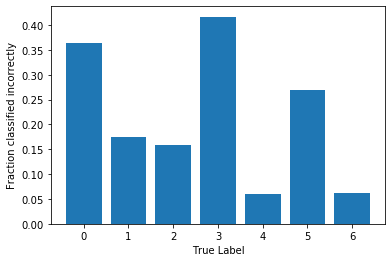

In [30]:
label_error = 1 - np.diag(matrix)/np.sum(matrix,axis=1)
plt.bar(np.arange(7),label_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')